In [1]:
from spotipy.oauth2 import SpotifyClientCredentials
from collections import Counter
import json
import os
import requests
import pandas as pd
import base64
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from dotenv import load_dotenv
load_dotenv()

True

Obtener las credenciales y el token de Spotify para poder acceder a la API y hacer consultas

In [2]:
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

def get_token():
    auth_str = f'{client_id}:{client_secret}'
    auth_bytes = auth_str.encode('utf-8')
    auth_base64 = str(base64.b64encode(auth_bytes), 'utf-8')
    
    url = 'https://accounts.spotify.com/api/token'
    
    headers = {
        'Authorization': f'Basic {auth_base64}',
        'Content-Type': 'application/x-www-form-urlencoded'}
    data = {'grant_type': 'client_credentials'}
    
    result = requests.post(url=url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

def get_auth_token(token):
    return {'Authorization': f'Bearer {token}'}

In [3]:
token = get_token()

Crear funciones para poder extraer la información

In [4]:
def get_top50_id(country):
    headers = get_auth_token(token)
    url = 'https://api.spotify.com/v1/search'
    query = f'?q=Top+50+{country}&type=playlist&limit=1'
    query_url = url + query
    
    result = requests.get(query_url, headers=headers)
    json_result = json.loads(result.content)
    
    return json_result['playlists']['items'][0]['id']

In [5]:
def get_song_id(song_url):
    prefix = 'https://open.spotify.com/track/'
    
    song_id = song_url.replace(prefix, '')
    
    return song_id

In [6]:
def genre_from_url(song_url):
    try:
        headers = get_auth_token(token)
        track_url = 'https://api.spotify.com/v1/tracks/'
        
        song_id = get_song_id(song_url)
        query_track = track_url + song_id
        result_track = requests.get(query_track, headers=headers)
        result_track.raise_for_status()  # Lanza una excepción para códigos de estado HTTP inesperados
        track_info = result_track.json()
        
        artist_id = track_info['artists'][0]['id']
        artists_url = 'https://api.spotify.com/v1/artists/'
        query_artists = artists_url + artist_id
        result_artists = requests.get(query_artists, headers=headers)
        result_artists.raise_for_status()  # Lanza una excepción para códigos de estado HTTP inesperados
        artist_info = result_artists.json()

        if artist_info['genres']:
            genre = artist_info['genres'][0]
        else:
            genre = 'Genre not found'
        
        return genre
    except requests.exceptions.RequestException as e:
        print("Error al realizar la solicitud HTTP:", e)
        return None
    except json.JSONDecodeError as e:
        print("Error al decodificar JSON:", e)
        return None

In [7]:
def top50_df(playlist_id):
    url = f'https://raw.githubusercontent.com/mackorone/spotify-playlist-archive/main/playlists/cumulative/{playlist_id}.json'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.json_normalize(data['tracks'])
        
        max_artists = 3
    
        for i in range(max_artists):
            df[f'artists_{i+1}_name'] = df['artists'].apply(lambda x: x[i]['name'] if i < len(x) else None)
        df = df.drop('artists', axis=1)
        
        return df
    else: print(f'Error {response.status_code}')

In [8]:
def get_song_and_artist(song_id):
    headers = get_auth_token(token)
    track_url = 'https://api.spotify.com/v1/tracks/'
    track_query = song_id
    track_info = track_url + track_query
    
    result = requests.get(track_info, headers=headers)
    json_result = json.loads(result.content)
    
    artist_name = json_result['artists'][0]['name']
    song_name = json_result['name']
    
    artist_and_song_name = f'{artist_name} - {song_name}'
    
    return artist_and_song_name

In [9]:
def search_for_genre(genre, song_url):    
    genre_match = genre_from_url(song_url)
    
    if genre == genre_match:
        song_id = get_song_id(song_url)
        song_and_artist = get_song_and_artist(song_id)
        
        return song_and_artist

Seleccionar el país del cuál queremos obtener la información histórica de la playlist 'Top 50' generada por Spotify y transformarlo en un DataFrame

In [10]:
country = 'argentina'

playlist_id = get_top50_id(country)
df = top50_df(playlist_id)
df = df.drop_duplicates(subset='name', keep='first')
df.reset_index(drop=True, inplace=True)
df

,date_added,date_added_asterisk,date_removed,duration_ms,name,url,album.name,album.url,artists_1_name,artists_2_name,artists_3_name
0,2024-03-13,False,2024-03-15,0,,https://open.spotify.com/track/3vz3SKnCyJCzPuX...,,https://open.spotify.com/album/2wDdeYLrljYWNLf...,,None,None
1,2023-06-24,False,2023-07-08,114053,01 dE ENEro,https://open.spotify.com/track/5KqaqJGPWgSJKVz...,Antes de Ameri,https://open.spotify.com/album/2A7S80QXLWlzw41...,Duki,Lucho SSJ,None
2,2023-09-02,False,2023-09-19,152425,1Amor,https://open.spotify.com/track/44FRdgBmwq8LEgD...,Spotify Singles,https://open.spotify.com/album/3sjYvK0dmsaQSqQ...,Lali,None,None
3,2021-06-27,False,2021-08-24,205714,2/Catorce,https://open.spotify.com/track/0PwFN7vRvY80Hnk...,VICE VERSA,https://open.spotify.com/album/5hKAQ3WuOJtaOW2...,Rauw Alejandro,Mr. Naisgai,None
4,2023-11-15,False,2023-11-17,137559,24/7 6.5,https://open.spotify.com/track/2wjzgkfw4MqYOtP...,EL AFTER DEL AFTER,https://open.spotify.com/album/4XDH5D7YsE7B8xu...,YSY A,Jere Klein,ONIRIA
...,...,...,...,...,...,...,...,...,...,...,...
636,2024-01-12,False,None,187172,"Young Miko: Bzrp Music Sessions, Vol. 58",https://open.spotify.com/track/6VciS3dRMpZhJiD...,"Young Miko: Bzrp Music Sessions, Vol. 58",https://open.spotify.com/album/0HMTQPl6rJmP7sQ...,Bizarrap,Young Miko,None
637,2023-11-30,False,2023-12-02,277831,You’re Losing Me (From The Vault),https://open.spotify.com/track/3CWq0pAKKTWb0K4...,You're Losing Me (From The Vault),https://open.spotify.com/album/5q3jthpn2h59P7p...,Taylor Swift,None,None
638,2023-02-19,False,2023-03-29,229426,¿Y pa la Wacha Loca? (con Salastkbron) - Remix,https://open.spotify.com/track/4IkSOwB9JRhq7oS...,¿Y pa la Wacha Loca? (con Salastkbron) [Remix],https://open.spotify.com/album/4Pg9HfkoILc1bvE...,Gusty dj,La Joaqui,L-Gante
639,2022-10-29,False,2023-01-02,191606,Éxtasis,https://open.spotify.com/track/2X8AGLwb9F0JzJ9...,Éxtasis,https://open.spotify.com/album/3pfyjuT8pPM0i9K...,Manuel Turizo,Maria Becerra,None


Obtener el género de cada canción utilizando un request al artista principal de la canción y accediendo al género principal asociado donde Spotify lo cataloga
(Esto debido a que Spotify no le da géneros a cada canción individualmente)

In [11]:
genre_list = []

for index, row in df.iterrows():
    song_url = df.iloc[index]['url']
    genre = genre_from_url(song_url)
    genre_list.append(genre)

In [16]:
counter = Counter(genre_list)
data = counter.most_common(21)
data = [(genre, count) for genre, count in data if genre != 'Genre not found']

Hacer un gráfico de barras para los 20 géneros principales del Top 50 histórico de Argentina

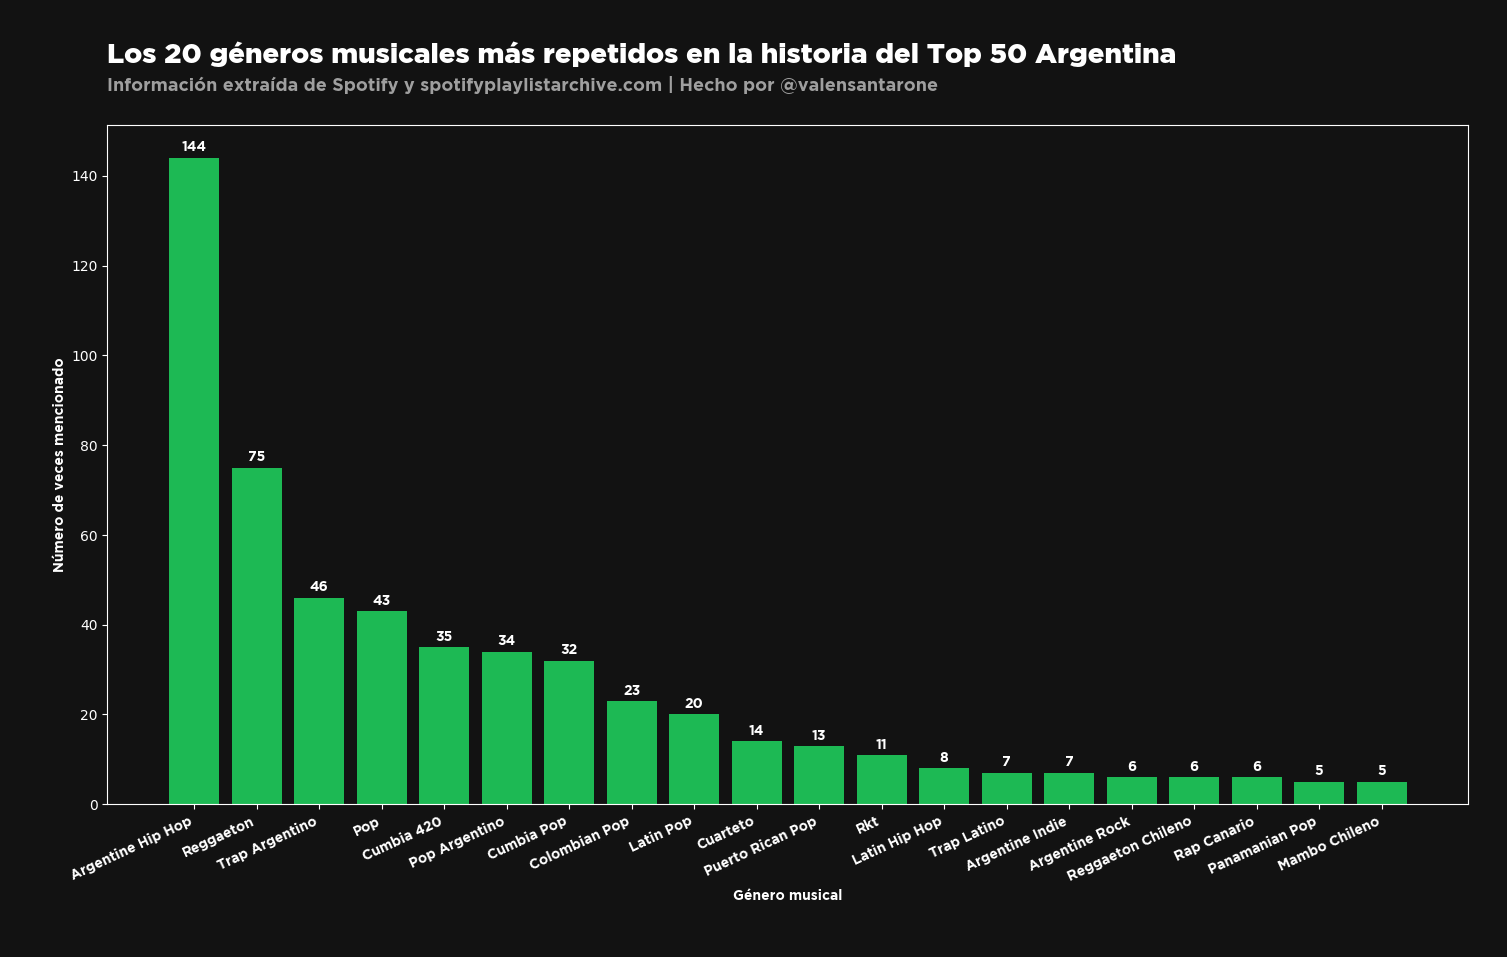

In [13]:
labels, values = zip(*data)

labels = [genre.title() for genre in labels]

custom_font_text_path = 'fonts/Gotham-Bold.otf'
custom_font_text = FontProperties(fname=custom_font_text_path)
custom_font_title_path = 'fonts/Gotham-Black.otf'
custom_font_title = FontProperties(fname=custom_font_title_path)

black = '#121212'
green = '#1DB954'
white = '#FFFFFF'

plt.figure(figsize=(15, 10), facecolor=black)
plt.gca().set_facecolor(black)
bars = plt.bar(labels, values, color=green)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, str(int(bar.get_height())), ha='center', va='bottom', fontproperties=custom_font_text, color=white)

plt.xlabel('Género musical', fontproperties=custom_font_text, color = white)
plt.ylabel('Número de veces mencionado', fontproperties=custom_font_text, color = white)
plt.title('Los 20 géneros musicales más repetidos en la historia del Top 50 Argentina', fontproperties=custom_font_title, x=0, y=1.08, horizontalalignment='left', fontsize=20, color = white)
plt.text(1.02, 1.16, ' ', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(-0.07, -0.2, ' ', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0, 1.06, 'Información extraída de Spotify y spotifyplaylistarchive.com | Hecho por @valensantarone', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, alpha=0.6, fontsize=13, fontproperties=custom_font_text, color = white)

plt.xticks(rotation=25, ha='right', fontproperties=custom_font_text, color = white)
plt.gca().tick_params(axis='both', colors=white)
plt.gca().spines['top'].set_color(white)
plt.gca().spines['right'].set_color(white)
plt.gca().spines['bottom'].set_color(white)
plt.gca().spines['left'].set_color(white)

plt.tight_layout()
plt.show()

Obtener la información de cuáles son las canciones que coinciden con el género que le proporcionemos, en este caso, rock argentino

In [14]:
genre_match_list = []
genre = 'argentine rock'

for index, row in df.iterrows():
    song_url = df.iloc[index]['url']
    genre_match = search_for_genre(genre, song_url)
    
    if genre_match:
        genre_match_list.append([genre_match])
        
genre_match_list

[['La Delio Valdez - Adiós Amor'],
 ['Fito Paez - Dos Días en la Vida - EADDA9223 (feat. Lali & Nicki Nicole)'],
 ['La Delio Valdez - Inocente'],
 ['Tan Bionica - La Melodía de Dios'],
 ['Rodrigo - Ocho Cuarenta'],
 ['Airbag - Por Mil Noches']]

Obtener la información de cuáles son los artistas que más veces aparecen el el Top 50 histórico

In [15]:
artists = df[['artists_1_name', 'artists_2_name', 'artists_3_name']]

artists_list = []

for index, row in artists.iterrows():
    for col in row:
        if pd.notnull(col) and col.strip() != '':
            artists_list.append(col)

top_artists = pd.Series(artists_list).value_counts()
top_artists.head(10)

Duki              57
Bad Bunny         43
Bizarrap          37
Maria Becerra     34
Tiago PZK         28
YSY A             23
Rauw Alejandro    22
Emilia            21
Nicki Nicole      20
Taylor Swift      19
Name: count, dtype: int64